<a href="https://colab.research.google.com/github/o93/bayesian-ab/blob/main/BayesianAB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


- [github](https://github.com/o93/bayesian-ab)
- [colab](https://colab.research.google.com/drive/1xkQ-KFfcyZXdXboOCALkDH_XCwQrsB25)

# 使い方

簡易的なベイジアンABテスト検証ツールです．

1. 左上「ファイル」から「ドライブにコピーを保存」すると更新可能になります
1. ABテストの現状の結果を入力します
    - アクセス数・CV数それぞれ1以上でないと判定できません
1. 判定のしきい値を入力します（任意
    - 例えば90%の確率でABの優劣を判定したい場合は，`0.9`と入力します
1. サンプルサイズを入力します（任意
    - サンプリングを多くすると処理に時間を要しますが，判定のブレが少なくなります
1. 左上の実行ボタンを押します

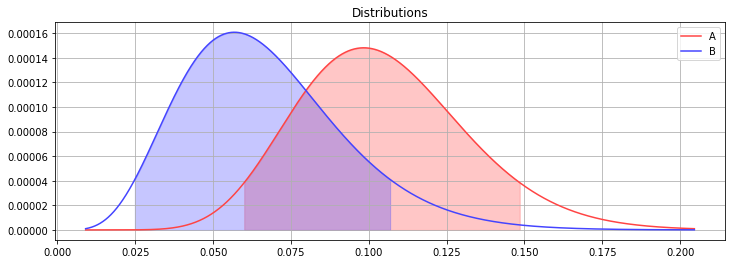

,アクセス数,CV数,CV率,誤差MIN,誤差MAX,確率,コメント
テストA,122,12,0.098361,0.05999,0.14848,0.86052,テストAが優位な確率は86.1%
テストB,88,5,0.056818,0.02486,0.10687,0.13948,テストBが優位な確率は13.9%


 
しきい値90.0%での判定: 優位差無し


In [ ]:
from IPython.core.display import publish_display_data
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns


def betaf(alpha, beta, rates):
    numerator = rates ** (alpha - 1) * (1 - rates) ** (beta - 1)
    return numerator / (numerator.sum())

def posterior(a, N, prior, rates):
    return betaf(a + 1, N - a + 1, rates)

def hmv(xs, ps, alpha):
    xps = sorted(zip(xs, ps), key=lambda xp: xp[1], reverse=True)
    xps = np.array(xps)

    xs = xps[:, 0]
    ps = xps[:, 1]

    return np.sort(xs[np.cumsum(ps) <= alpha])

def plot_p(name, rates, v, hm, c):
    plt.plot(rates, v, label=name, color=c)

    region = (hm.min() < rates) & (rates < hm.max())
    plt.fill_between(rates[region], v[region], 0, alpha=0.3, color=c)

# 実行
def execute_ab(a, b, threshold, sample_size):
    # データフレーム
    f = pd.DataFrame([a, b], index=['テストA', 'テストB'], columns=['アクセス数','CV数'])
    f['CV率'] = f['CV数'] / f['アクセス数']

    rates = np.linspace(0, 1, sample_size + 1, dtype=np.float128)
    ra = 1 / len(rates)
    rb = 1 / len(rates)

    # 確率分布
    pa = posterior(a[1], a[0], ra, rates)
    pb = posterior(b[1], b[0], rb, rates)

    # 誤差
    ha = hmv(rates, pa, alpha=threshold)
    hb = hmv(rates, pb, alpha=threshold)

    f['誤差MIN'] = (np.min(ha), np.min(hb))
    f['誤差MAX'] = (np.max(ha), np.max(hb))

    # 表示範囲を限定
    plot_index = np.where((pa > 0.000001) | (pb > 0.000001))
    p_rates = rates[plot_index]
    p_pa = pa[plot_index]
    p_pb = pb[plot_index]

    # 確率分布を表示
    plt.figure(figsize=(12, 4))
    plot_p('A', p_rates, p_pa, ha, '#FF4444')
    plot_p('B', p_rates, p_pb, hb, '#4444FF')
    plt.title('Distributions')
    plt.legend()
    plt.grid(True)
    plt.show()

    # AB数を揃えたサンプリング
    sa = np.random.beta(a[1], a[0], size=sample_size // 2)
    sb = np.random.beta(b[1], b[0], size=sample_size // 2)

    print(' ')

    # 優位確率
    delta_a = sa - sb
    delta_b = sb - sa
    
    f.loc[f.index == 'テストA', '確率'] = (delta_a > 0).mean()
    f.loc[f.index == 'テストB', '確率'] = (delta_b > 0).mean()

    f['コメント'] = f.index + 'が優位な確率は' + (f['確率'] * 100).round(1).astype(str) + '%'

    # データフレームを表示
    display(f)

    print(' ')

    win = f[f['確率'] > threshold]
    if win.shape[0] == 0:
        print('しきい値{:.1%}での判定: 優位差無し'.format(threshold))
    else:
        print('しきい値{:.1%}での判定: {}の勝利！'.format(threshold, win.index.values[0]))

#@markdown ABそれぞれに(アクセス数, CV数)を入力
a = (122, 12) #@param {type:"raw"}, {type:"raw"}
b = (88, 5) #@param {type:"raw"}    

#@markdown しきい値を入力
threshold = 0.9 #@param {type:"number", min:0.0, max:1.0}

#@markdown サンプルサイズを入力
sample_size = 100000 #@param {type:"integer", min:0, max:1000000}

if a[0] == 0 or a[1] == 0 or b[0] == 0 or b[1] == 0:
    print('a, bには0より大きい値を入力してください！')
else:
    execute_ab(a, b, threshold, sample_size)